In [1]:
import sys
import requests
import json
import datetime
import os
import pandas as pd
import numpy as np
import os
from dateutil.relativedelta import relativedelta
import pytz
import matplotlib.dates as mdates
import json
import math
import ast
from sys import stdout as out
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
def get_dev_info(device, address):
    
    r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']
    
    # get devid by serial name
    r1 = requests.get(
        url=address + "/api/tenant/devices?deviceName=" + device,
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    label = r1['label']
    devid = r1['id']['id']
    r1 = requests.get(
        url=address + "/api/device/" + devid + "/credentials",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    devtoken = r1['credentialsId']

    
    
    return devid,devtoken,acc_token,label
    
    

def get_attr(acc_token,devid,address):
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/attributes?keys=nominal",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    nominal = r2[0]['value']

    return nominal





def read_data(acc_token, devid, address, start_time, end_time, descriptors):

        
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    if r2:
        df = pd.DataFrame([])
        
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1['ts'] = df1['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)            
            
            df = pd.concat([df, df1], axis=1)

        if df.empty:
            df = pd.DataFrame([])
        else:
            for col in df.columns:
                df[col] = df[col].astype('float64')
    else:
        df = pd.DataFrame([])
        # print('Empty json!')
    return df


In [3]:
# os.chdir('C:/Users/EmilyP/meazon/Meazon-PROJECTS - DEDDIE-analysis/KPIs Summary/Graphs/')
# os.getcwd()

In [4]:
startTs = {}
startTs['Jan'] = '1704060000000'
startTs['Feb'] = '1706738400000'
startTs['Mar'] = '1709244000000'
startTs['Apr'] = '1711918800000'
startTs['May'] = '1714510800000'

endTs = {}
endTs['Jan'] = '1706738400000'
endTs['Feb'] = '1709244000000'
endTs['Mar'] = '1711918800000'
endTs['Apr'] = '1714510800000'
endTs['May'] = '1717189200000'

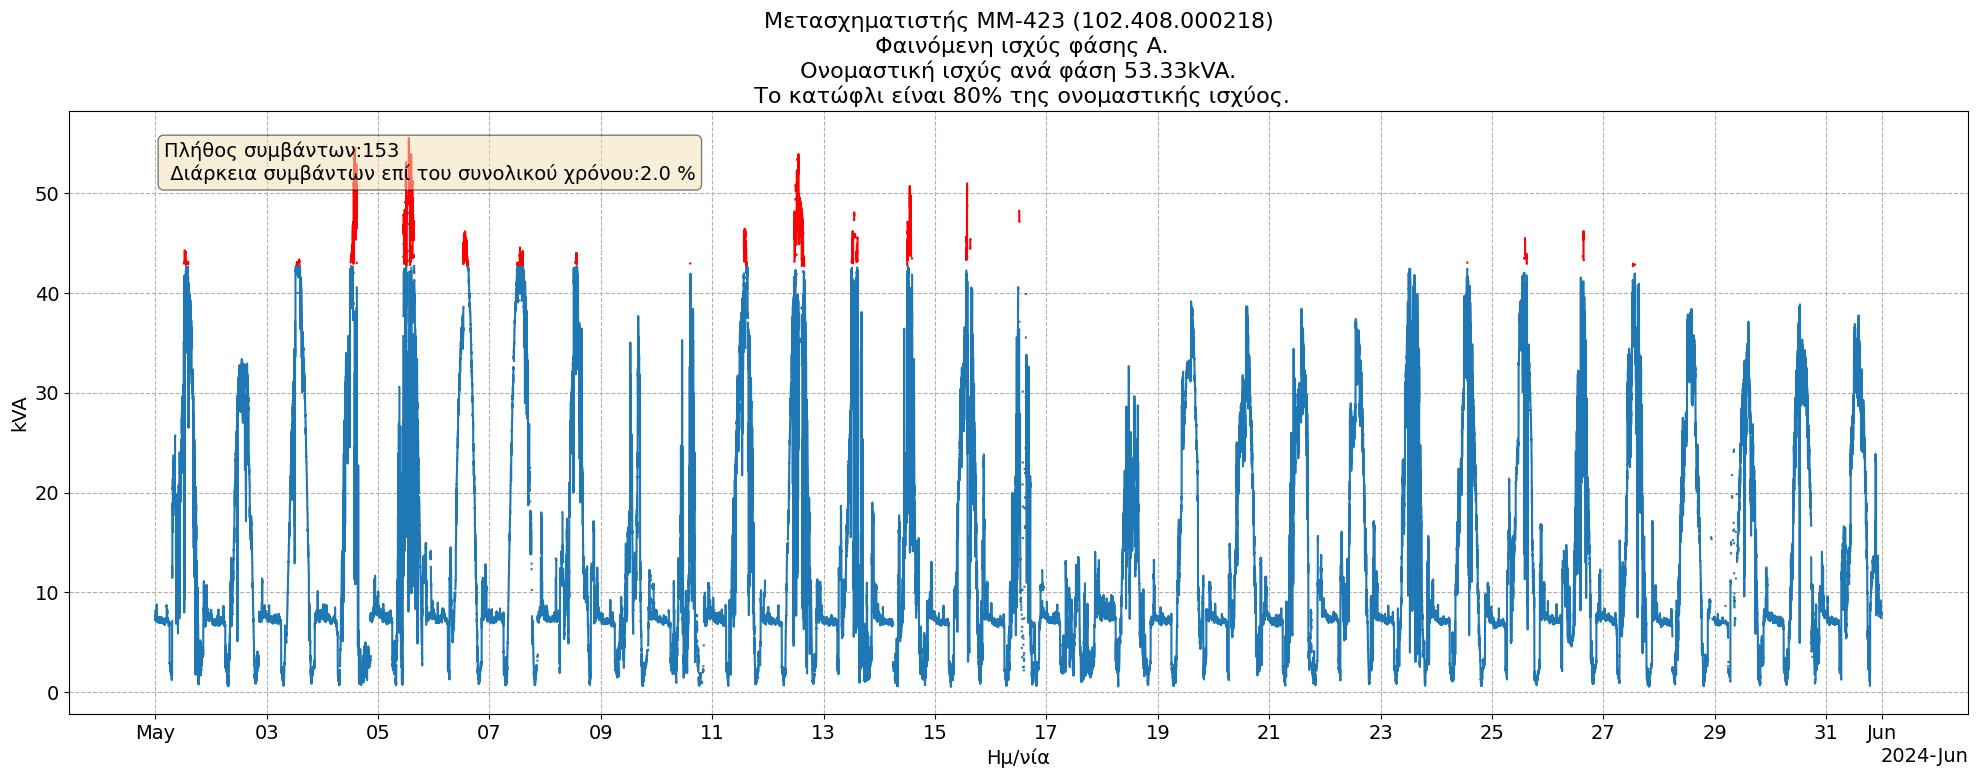

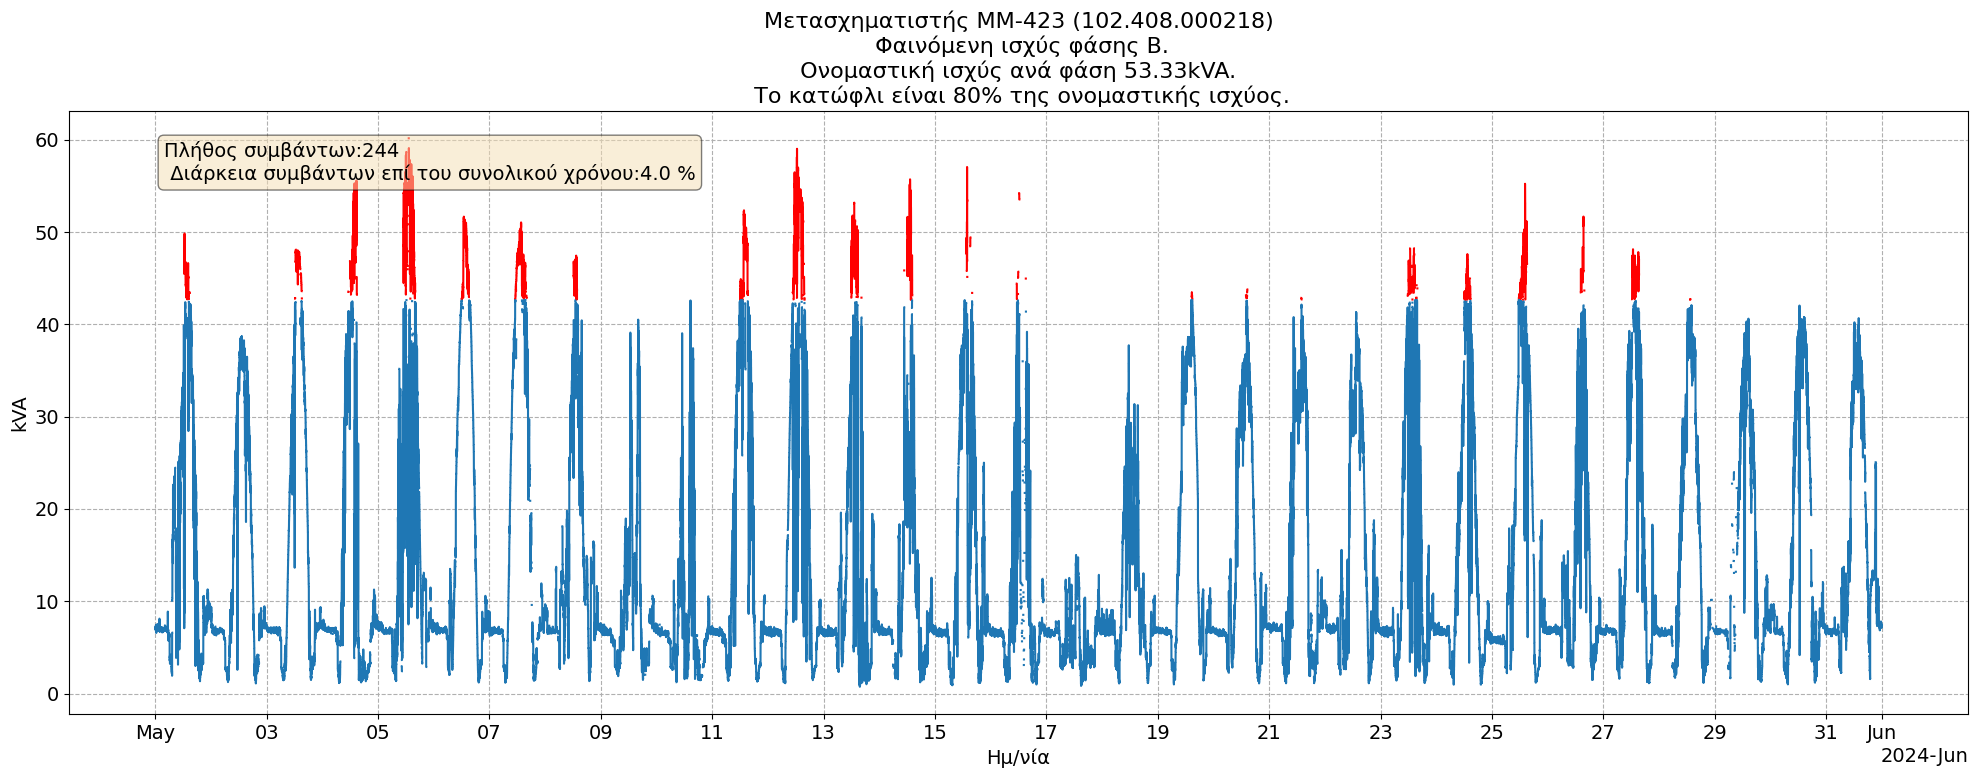

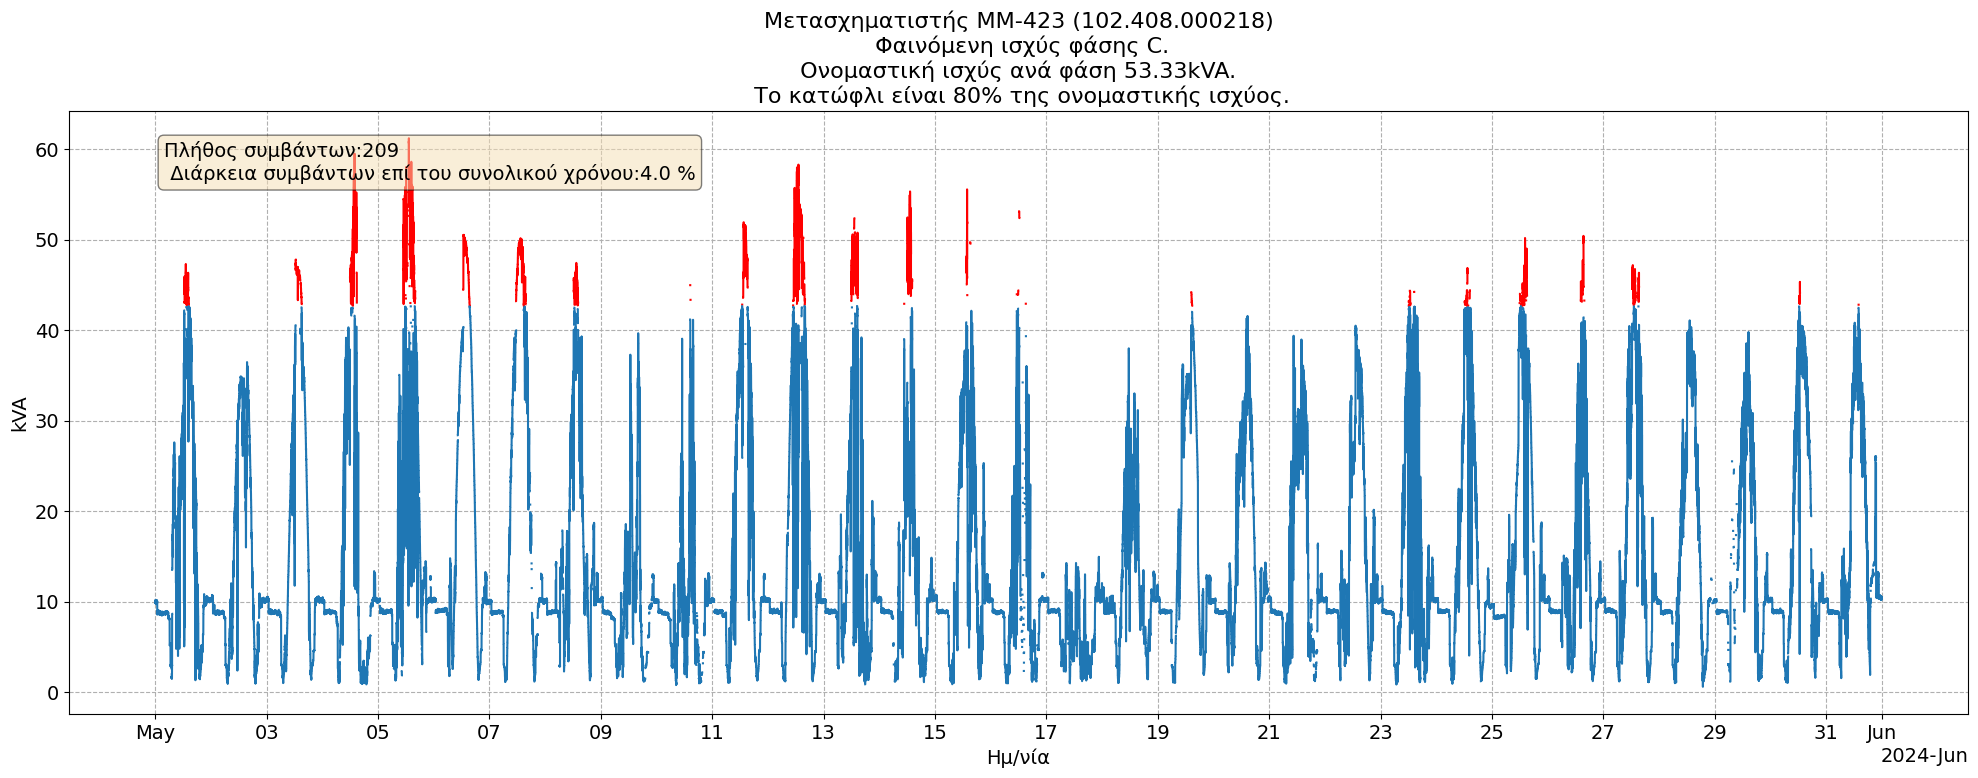

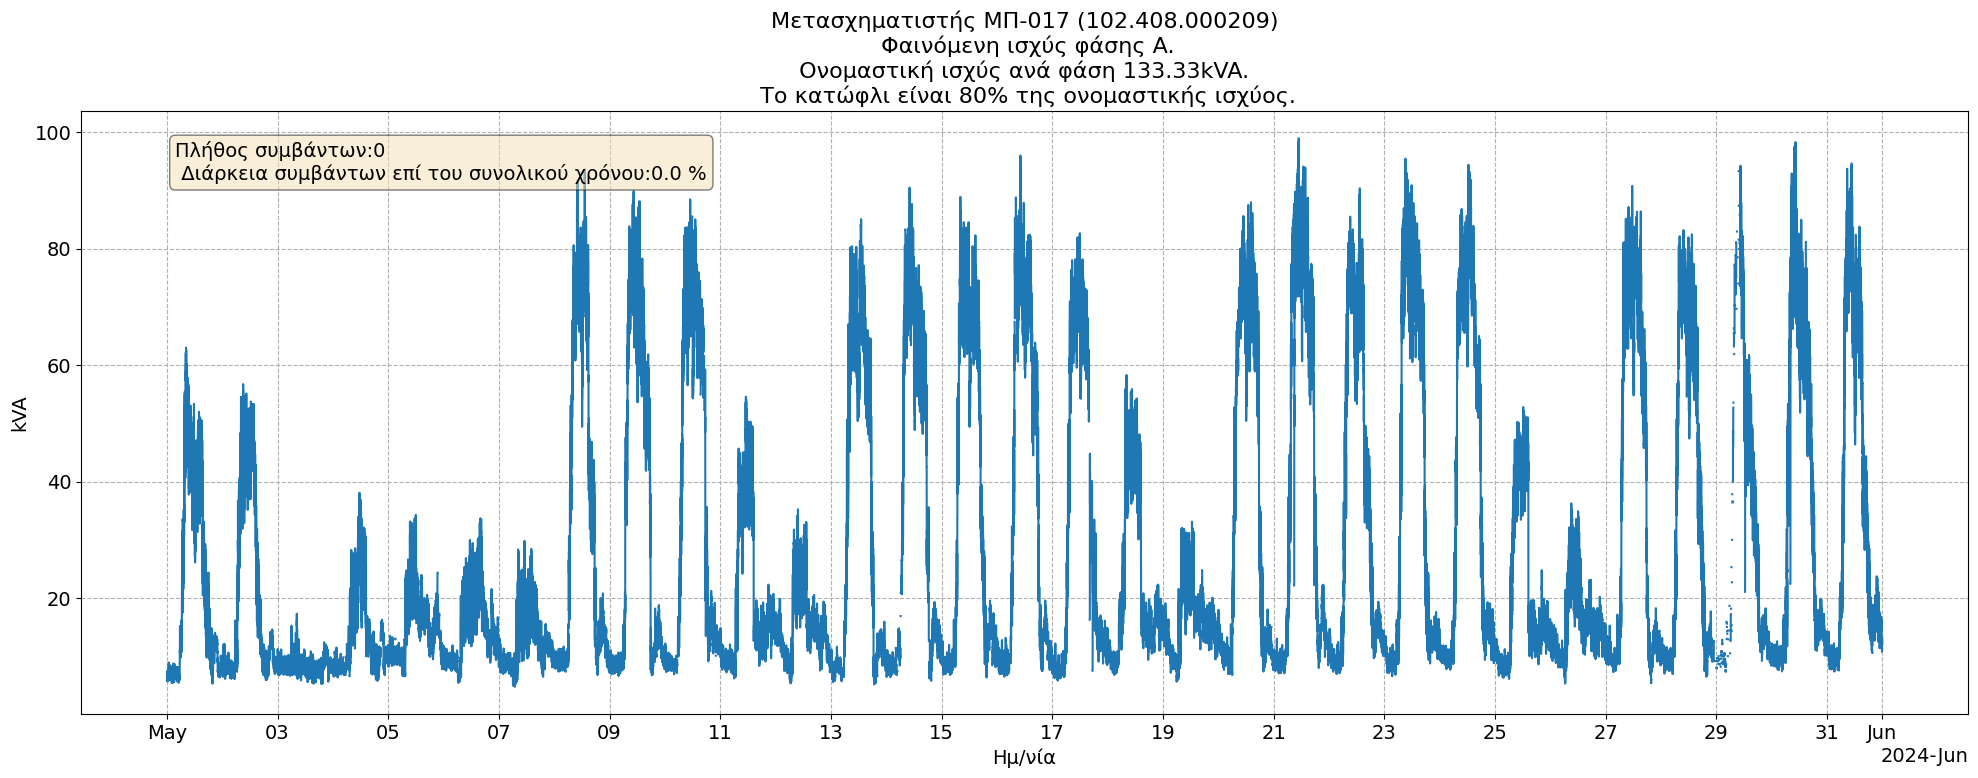

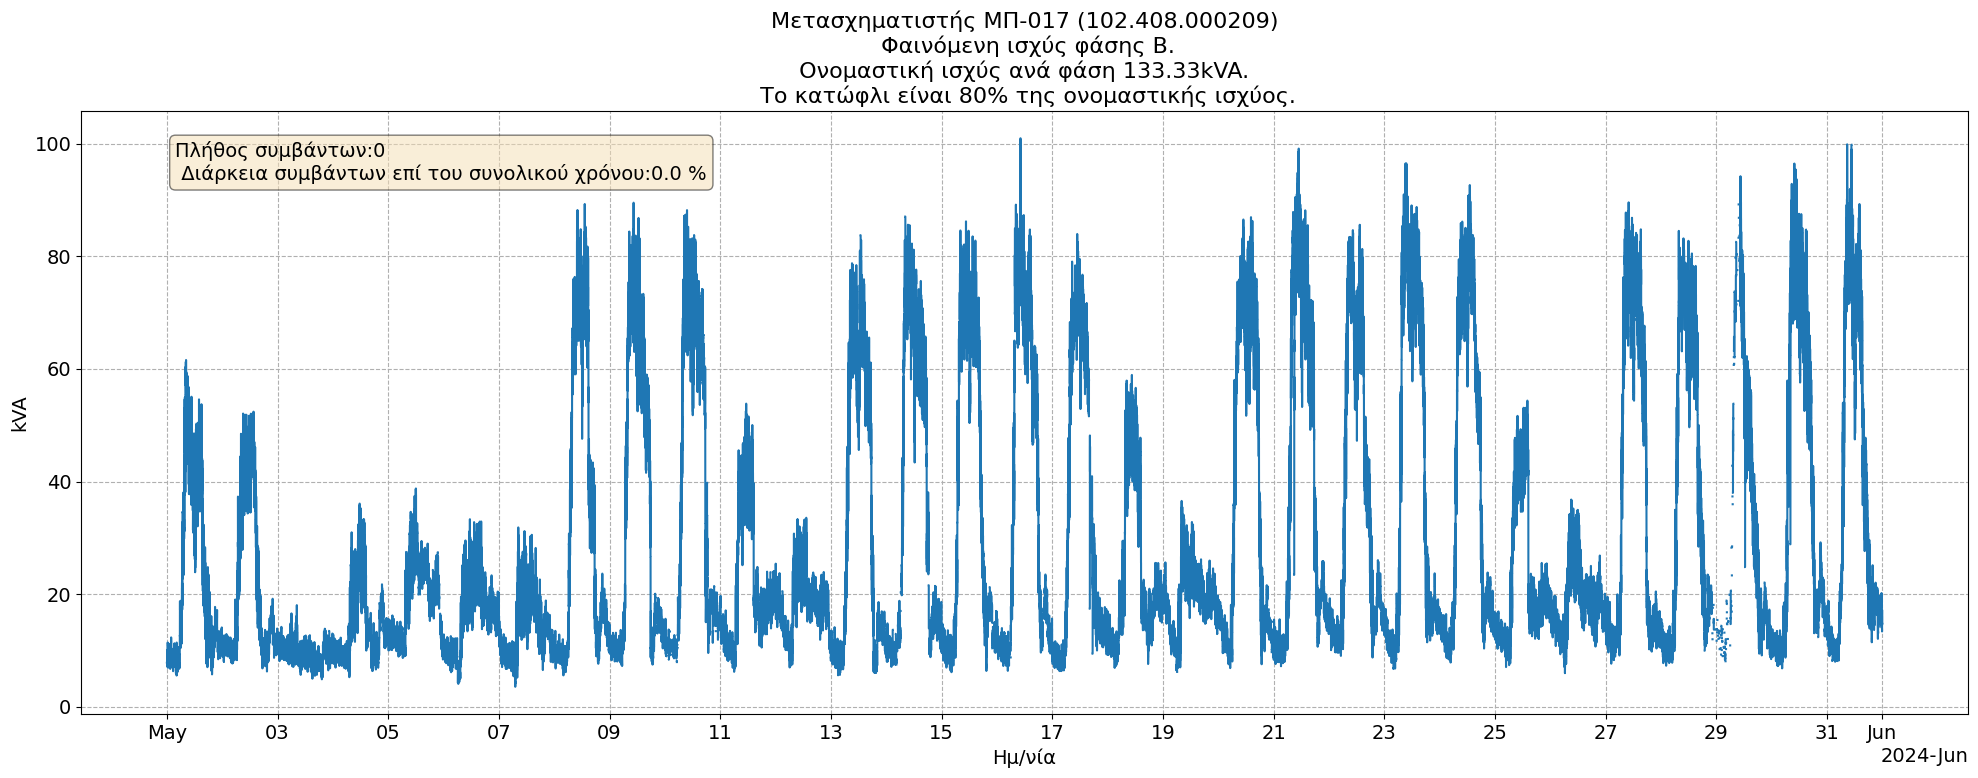

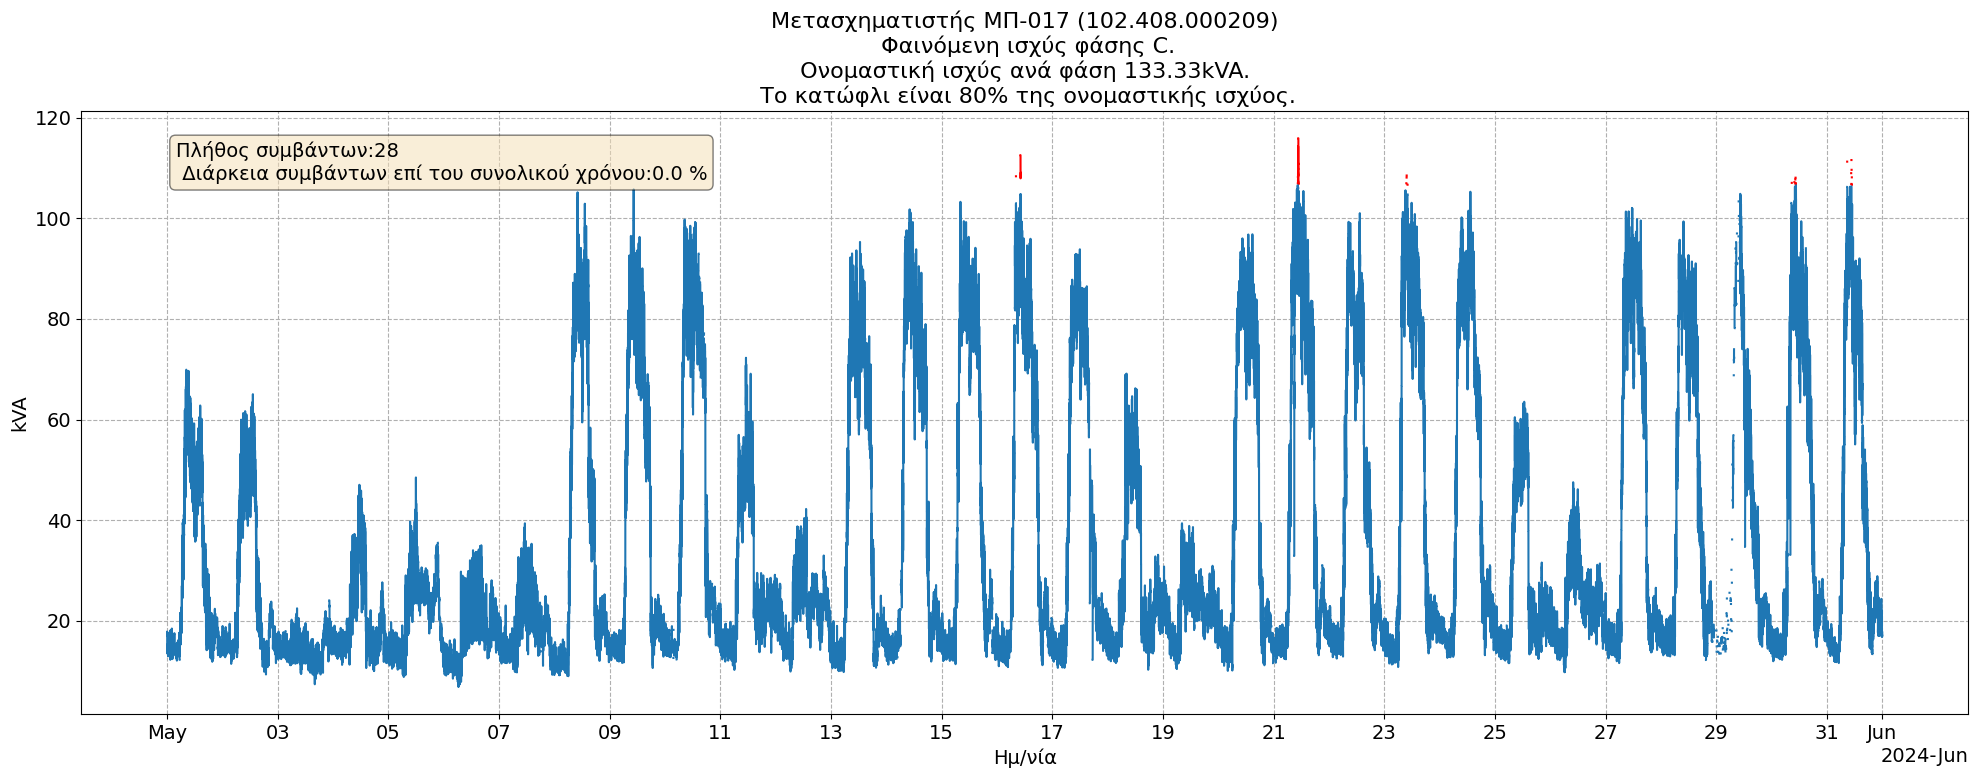

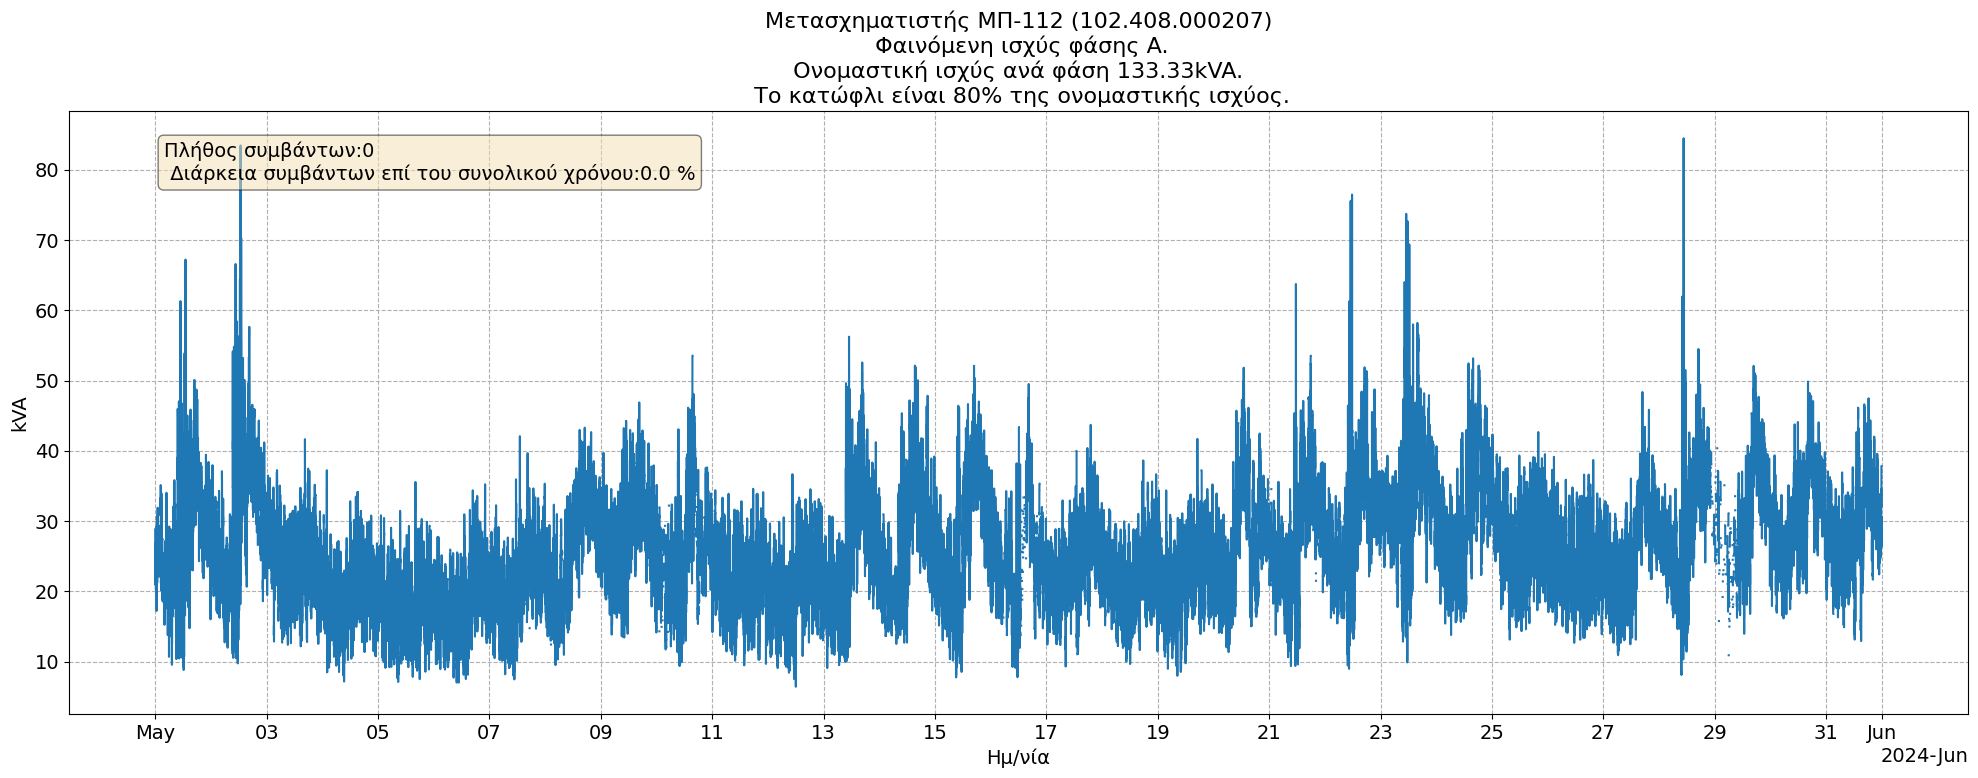

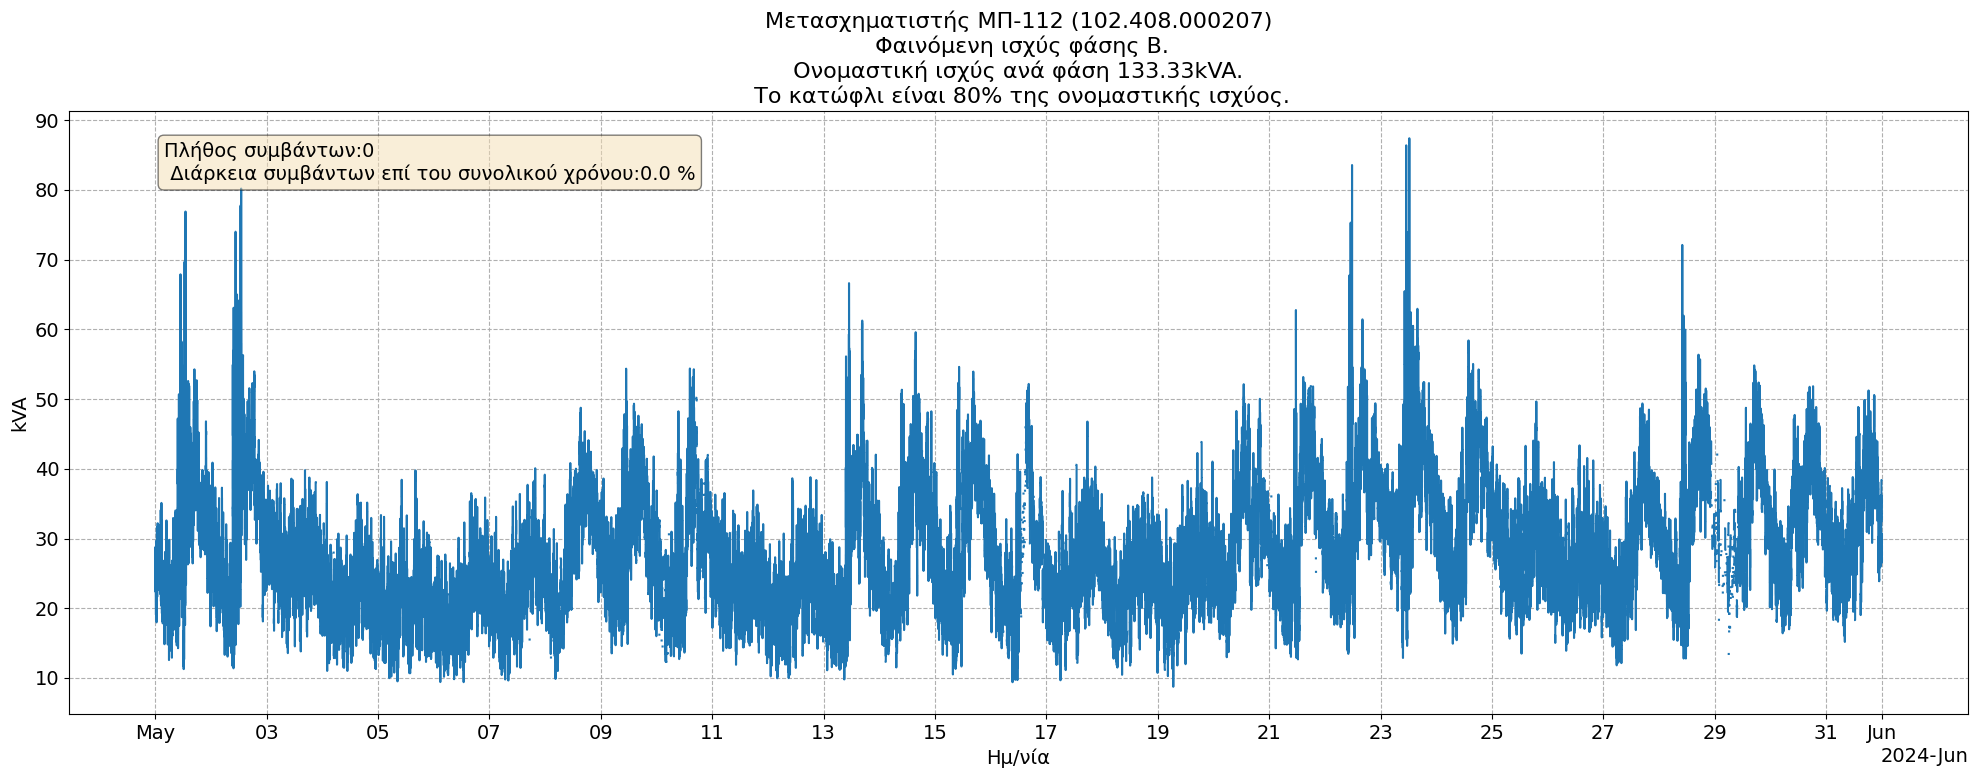

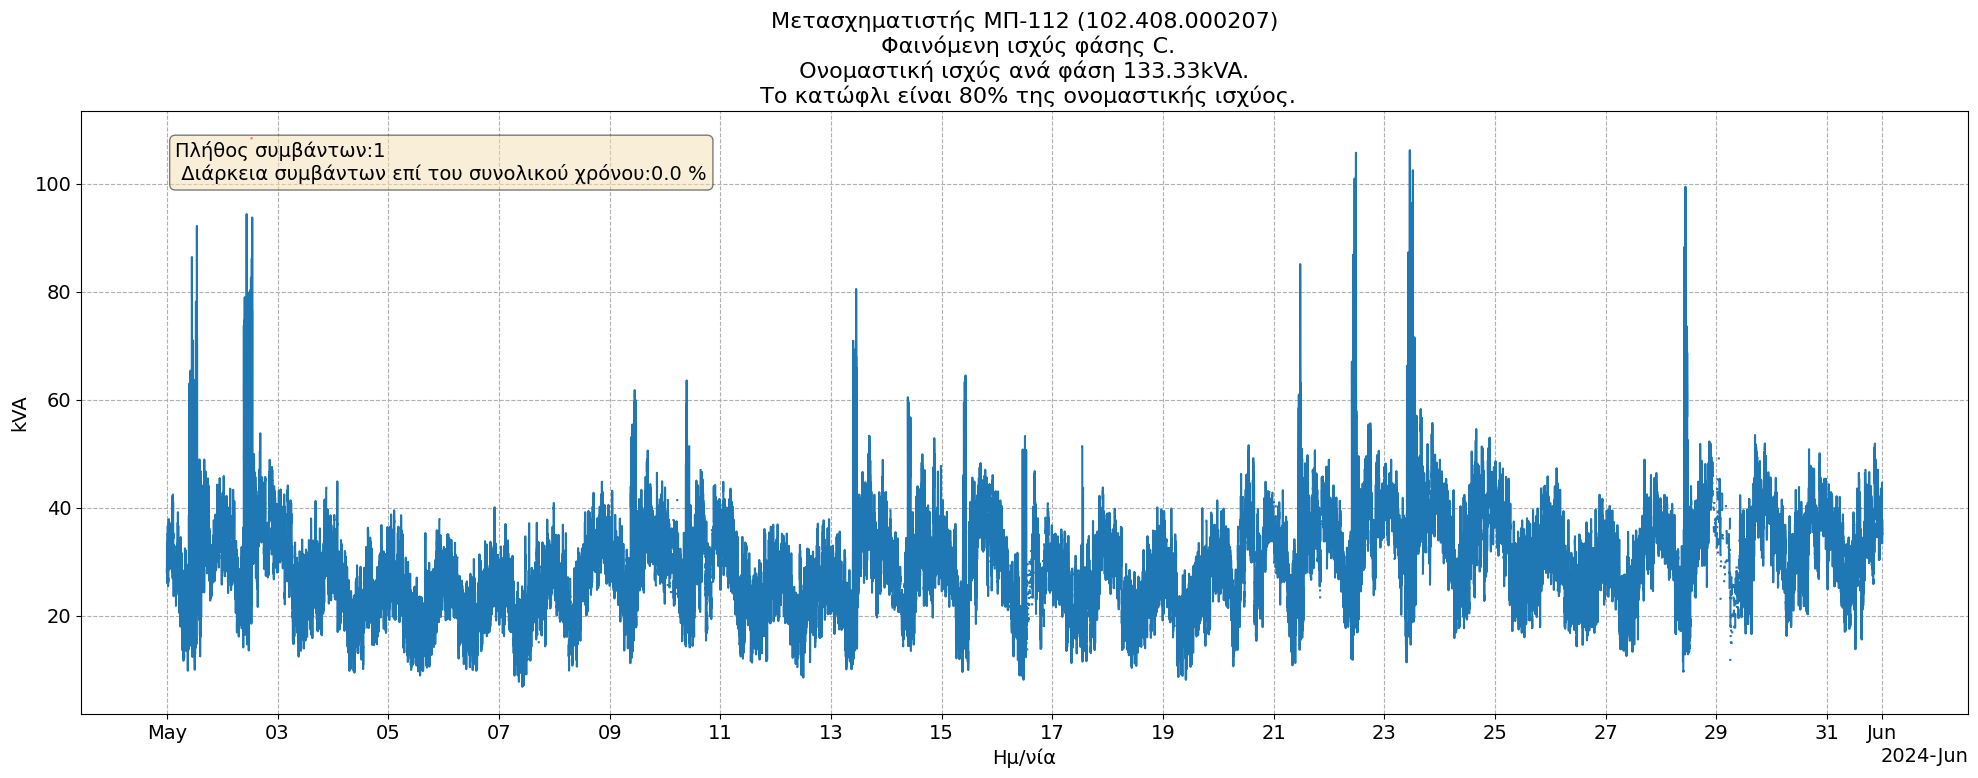

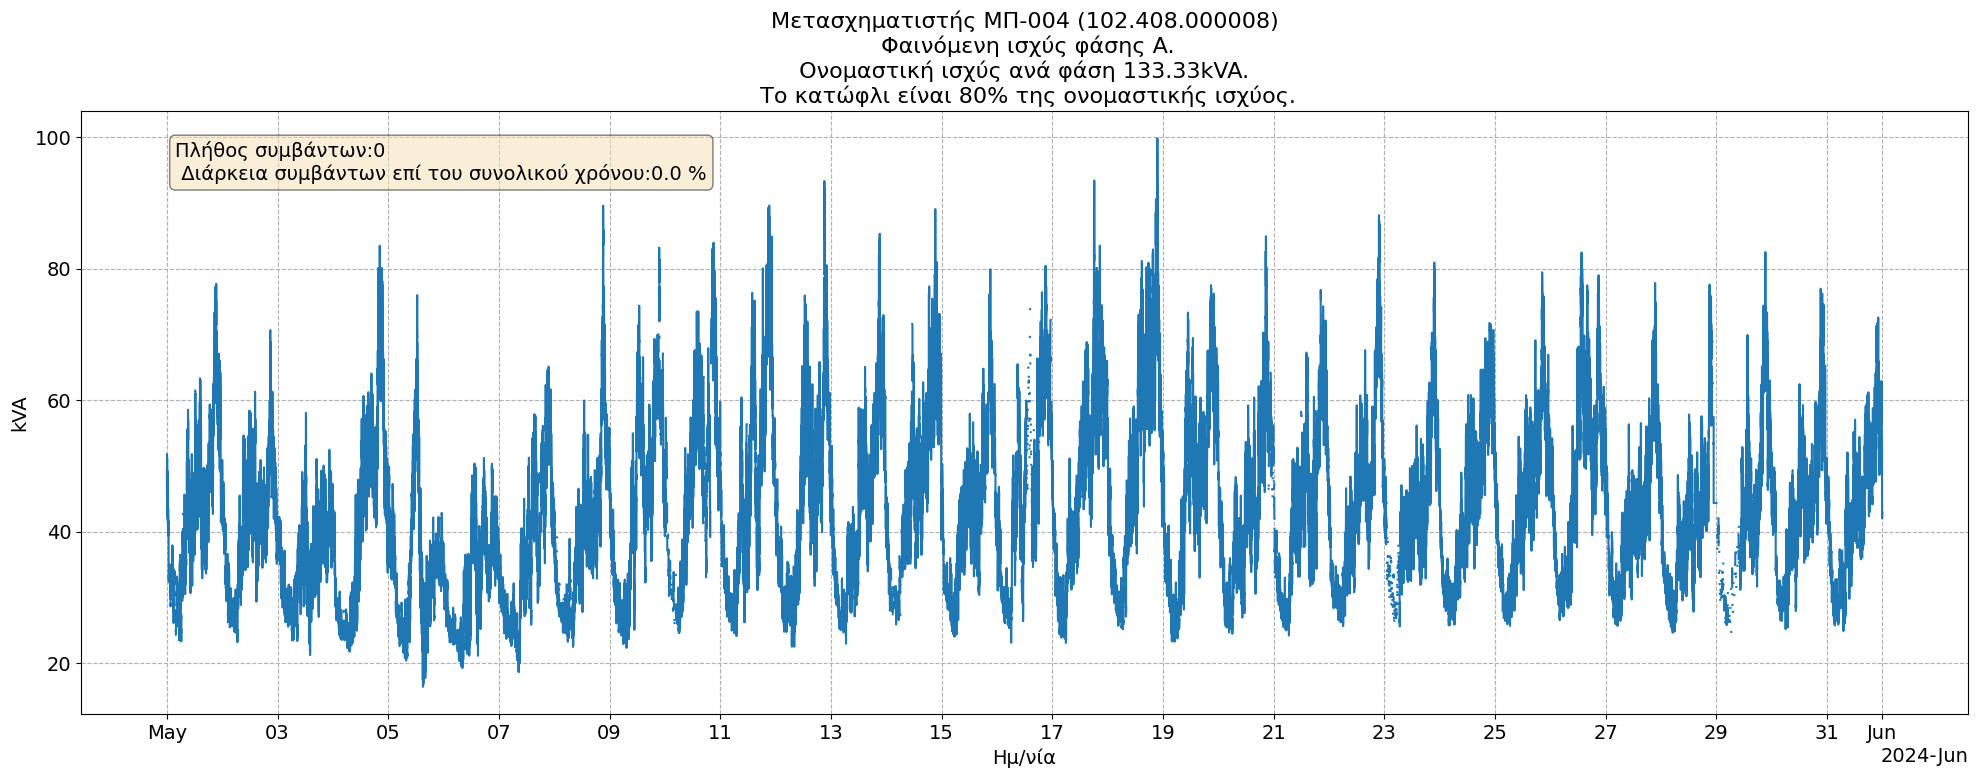

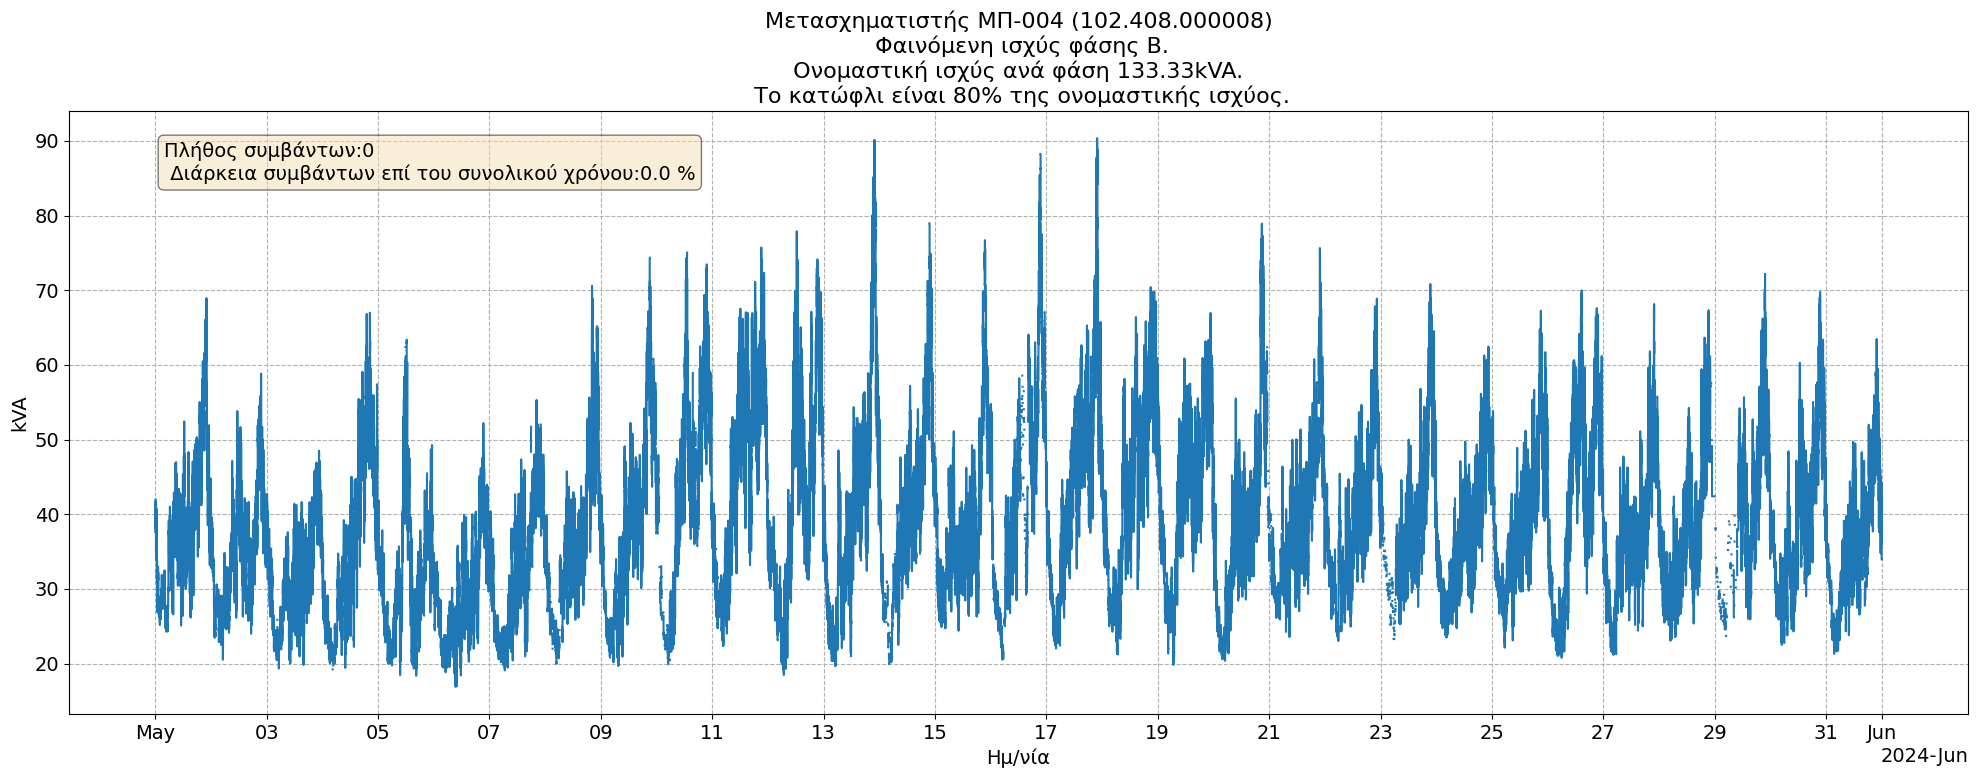

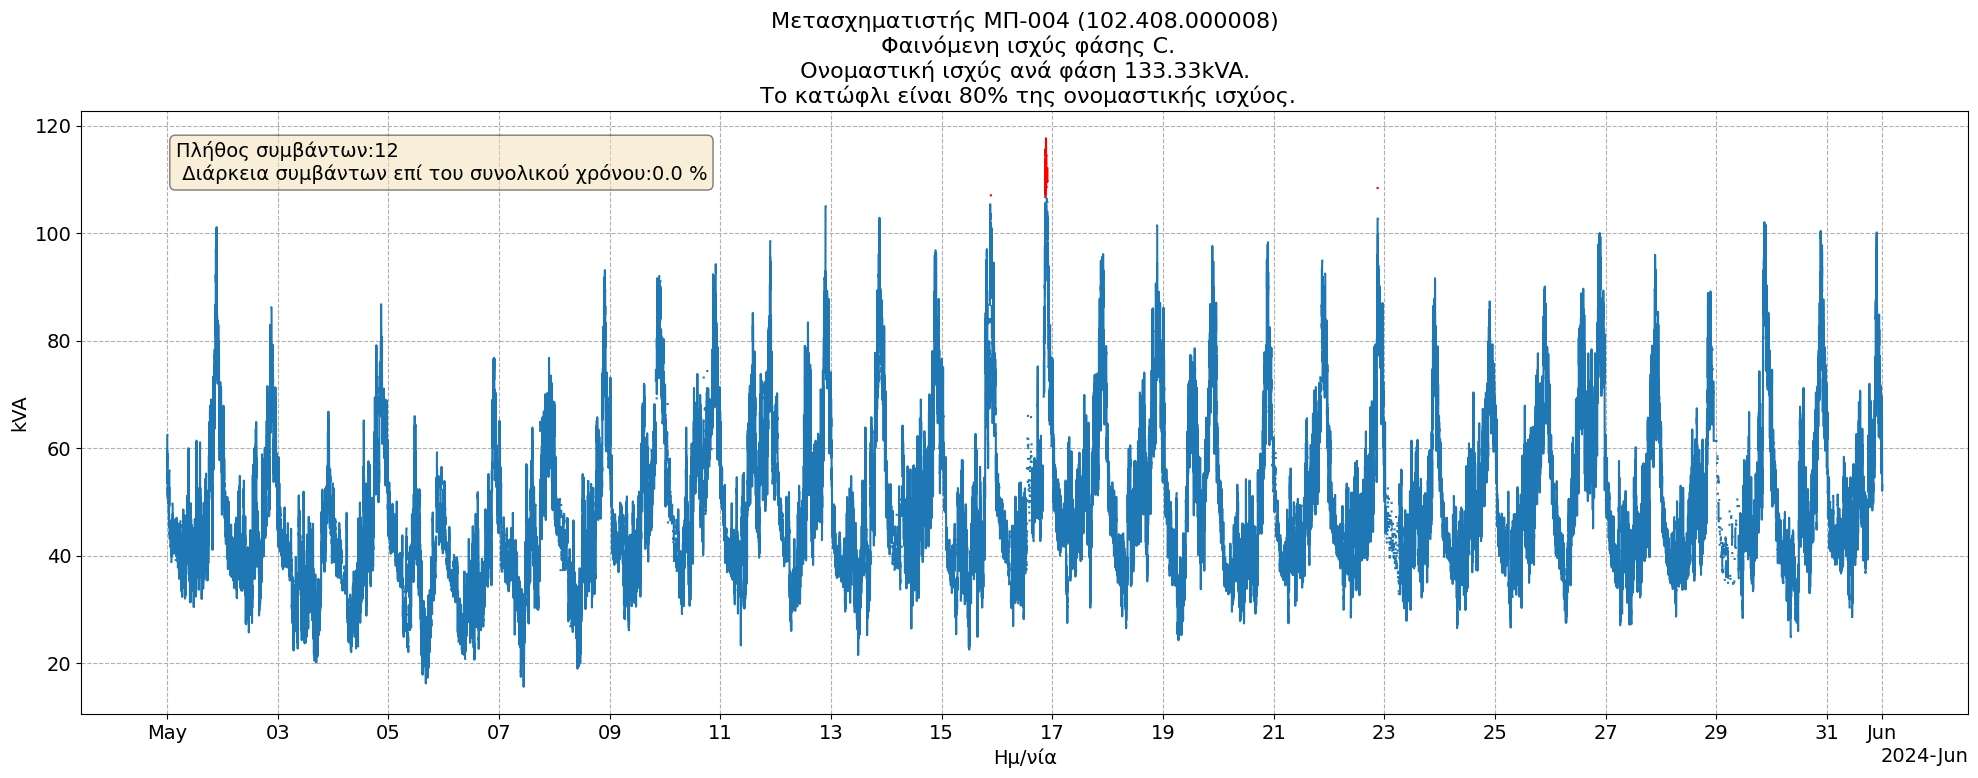

In [7]:


address = 'https://mi6.meazon.com'

r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
acc_token = 'Bearer' + ' ' + r['token']


entityId = '47545f30-5b7f-11ee-b2c9-653b42f73605' # DEDDHE ATHINAS
r1 = requests.get(url=address + "/api/entityGroup/"+entityId+"/entities?pageSize=1000&page=0",headers={'Content-Type': 'application/json', 
'Accept': '*/*', 'X-Authorization': acc_token}).json()

monthdict = {'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5'}
# for name in ['Jan','Feb','Mar','Apr','May']:
for name in ['May']:
    os.chdir('E:/VSprojects/thingsboard/mi6/deddhePDF/')
    df = pd.read_excel('HEDNO_KPIs_simplified_'+monthdict[name]+'_2024.xlsx', engine='openpyxl')
    os.chdir('C:/Users/EmilyP/meazon/Meazon-PROJECTS - DEDDIE-analysis/KPIs Summary/Graphs/')
    df = df.loc[df['Nr. of power alarms']>0]
    installations = df['Installation'].values
    transformers = df['Transformer'].values
    if not os.path.exists(str(name)):
        os.makedirs(str(name))
    os.chdir(str(name))

    for i in range(0,len(r1['data'])):
        assetid = r1['data'][i]['id']['id']
        assetname = r1['data'][i]['name']
        
        if assetname in installations:
            r2 = requests.get(url=address + "/api/relations/info?fromId="+assetid+"&fromType=ASSET",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

            for j in range(0, len(r2)):
                device = r2[j]['toName']
                
                # Define variables
                # device = '102.408.000008'
                local_tz = pytz.timezone('Europe/Athens')
                interval = 1
                descriptors = 'curA,curB,curC,vltA,vltB,vltC'
                start_time = startTs[name] 
                end_time = endTs[name]

                # extract info
                [devid, _, acc_token,label] = get_dev_info(device, address)
                if label in transformers:
                    if not os.path.exists(label+'_'+str(device)):
                        os.makedirs(label+'_'+str(device))
                    os.chdir(label+'_'+str(device))

                    nominal = get_attr(acc_token,devid,address)


                    # read data
                    timethres = 12*3600000
                    svec = np.arange(int(start_time),int(end_time),timethres)

                    df = pd.DataFrame([])

                    for st in svec:
                        en = st+timethres-1
                        
                        if int(end_time)-en<=0: en = int(end_time)
                        tmp = read_data(acc_token, devid, address,  str(st), str(en), descriptors)
                        if not tmp.empty:
                            tmp = tmp.resample(str(interval)+'T').mean()
                            # tmp = tmp.dropna()
                            df = pd.concat([df,tmp])

                    del tmp
                    df.sort_index(inplace=True)

                    # calculate new variables
                    for ph in ['A','B','C']:
                        df['apwr'+ph] = df['vlt'+ph]*df['cur'+ph]

                    df['totalcur'] = df['curA']+df['curB']+df['curC']
                    nomphase = 1000*np.round(nominal/3,2)

                    # Find power alarms
                    for ph in ['A','B','C']:
                        df['pwrAlarm'+ph] = np.nan
                        df.loc[df['apwr'+ph]>0.8*nomphase, 'pwrAlarm'+ph] = 1

                    # create groups
                    for ph in ['A','B','C']:
                        ind=0
                        df['alarm'+ph] = np.nan
                        for i in range(1,df.shape[0]):
                            if ((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]!=1)):
                                ind+=1
                                df['alarm'+ph].iloc[i]=ind
                            elif((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]==1)):
                                df['alarm'+ph].iloc[i]=ind


                    # Plot power alarms
                    for ph in ['A','B','C']:
                        #overall duration within time range
                        dtPerc = 100*np.round(df.describe()['alarm'+ph]['count']/df.describe()['cur'+ph]['count'],2)
                        # number of distinct events/alarms
                        events = df.groupby('alarm'+ph).ngroups

                        local_tz = pytz.timezone('Europe/Athens')
                        fig, ax = plt.subplots(figsize=(20, 8.0))

                        plt.step(df.index,np.where(df['pwrAlarm'+ph]==1,df['apwr'+ph]/1000, None), color="red", label="1")
                        plt.step(df.index,np.where(df['pwrAlarm'+ph]!=1,df['apwr'+ph]/1000, None), color="tab:blue", label="1")

                        # plt.setp(ax.xaxis.get_majorticklabels())
                        # plt.step(df.index, df['apwrA'], where='post')

                        plt.xlabel('Ημ/νία')
                        plt.ylabel('kVA')

                        # filtered = df['alarmA']>=1
                        # ax.scatter(df.index[filtered], df['apwrA'][filtered], color='red') 

                        ax.xaxis.set( 
                        major_locator = mdates.AutoDateLocator(minticks = 1, 
                                                                maxticks = 5,tz=local_tz), 
                        ) 

                        locator = mdates.AutoDateLocator(minticks = 5, 
                                                        maxticks = 20,tz=local_tz) 
                        formatter = mdates.ConciseDateFormatter(locator,tz=local_tz) 

                        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                        textstr = 'Πλήθος συμβάντων:'+str(events)+'\n Διάρκεια συμβάντων επί του συνολικού χρόνου:'+str(dtPerc)+' %'
                        
                        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                            verticalalignment='top', bbox=props)
                        ax.grid(linestyle = "dashed")
                        ax.xaxis.set_major_locator(locator) 
                        ax.xaxis.set_major_formatter(formatter)
                        ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Φαινόμενη ισχύς φάσης '+ph+'.\n Ονομαστική ισχύς ανά φάση '+str(nomphase/1000)+'kVA. \n Το κατώφλι είναι 80% της ονομαστικής ισχύος.')
                        ax.title.set_size(16)
                        fig.tight_layout()
                        plt.savefig('pwrAlarm'+str(ph)+'.png',dpi=150)

                    os.chdir('..')
    os.chdir('..')

In [85]:
dtPercA = 100*df.describe()['alarmA']['count']/df.describe()['curA']['count']
dtPercB = 100*df.describe()['alarmB']['count']/df.describe()['curB']['count']
dtPercC = 100*df.describe()['alarmC']['count']/df.describe()['curC']['count']

eventsA = df.groupby('alarmA').ngroups
eventsB = df.groupby('alarmB').ngroups
eventsC = df.groupby('alarmC').ngroups



11.678415673077852 8.948584800750389 33.51802964811001


<AxesSubplot: >

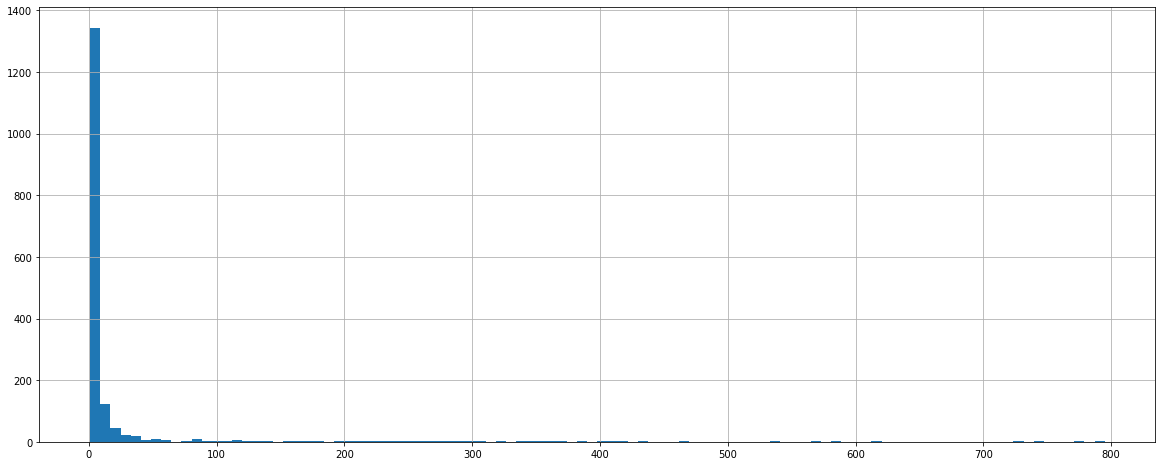

In [115]:
df.groupby('alarmC').size().hist(bins=100, figsize=[20,8])

In [5]:
os.getcwd()

'e:\\Meazon Projects\\thingsboard\\mi6\\deddhePDF'

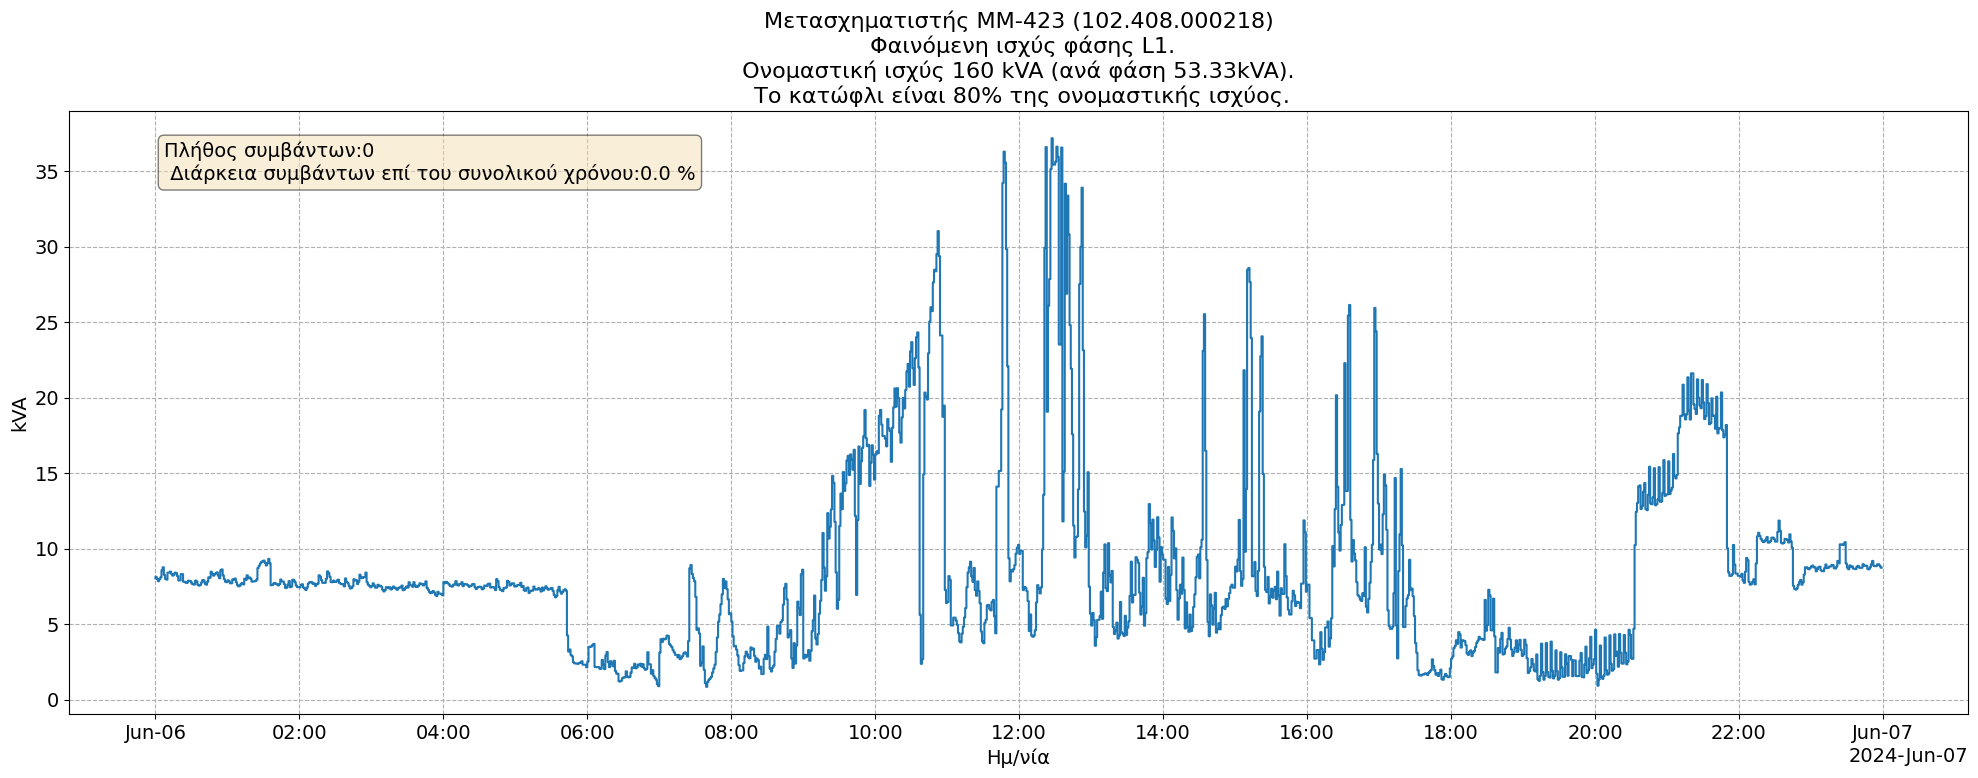

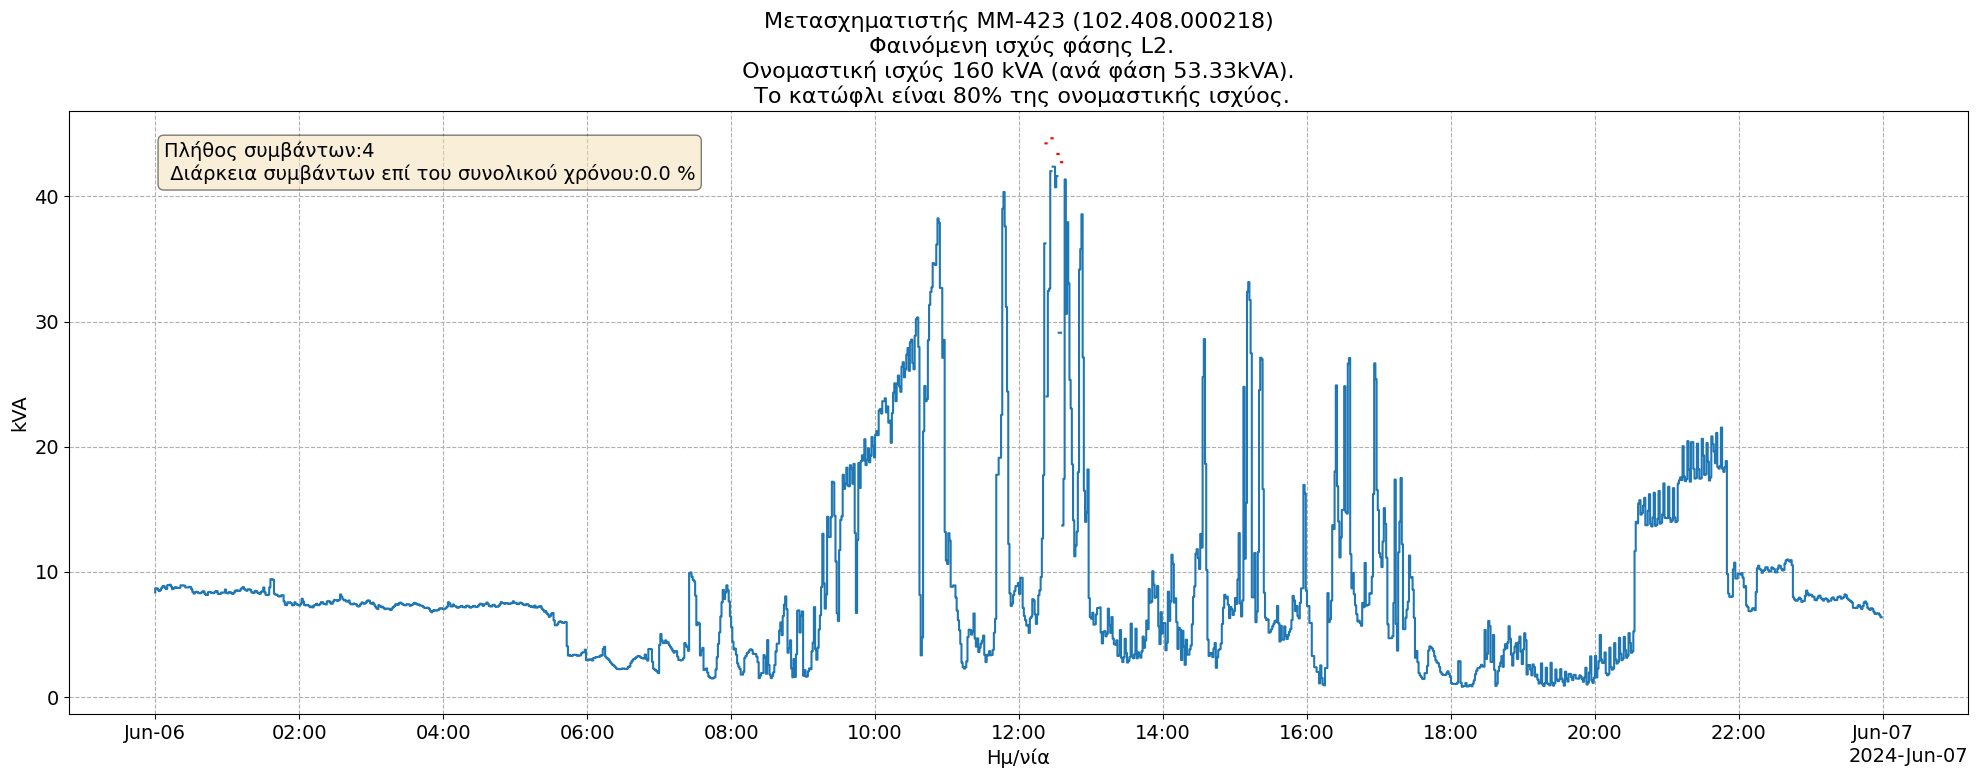

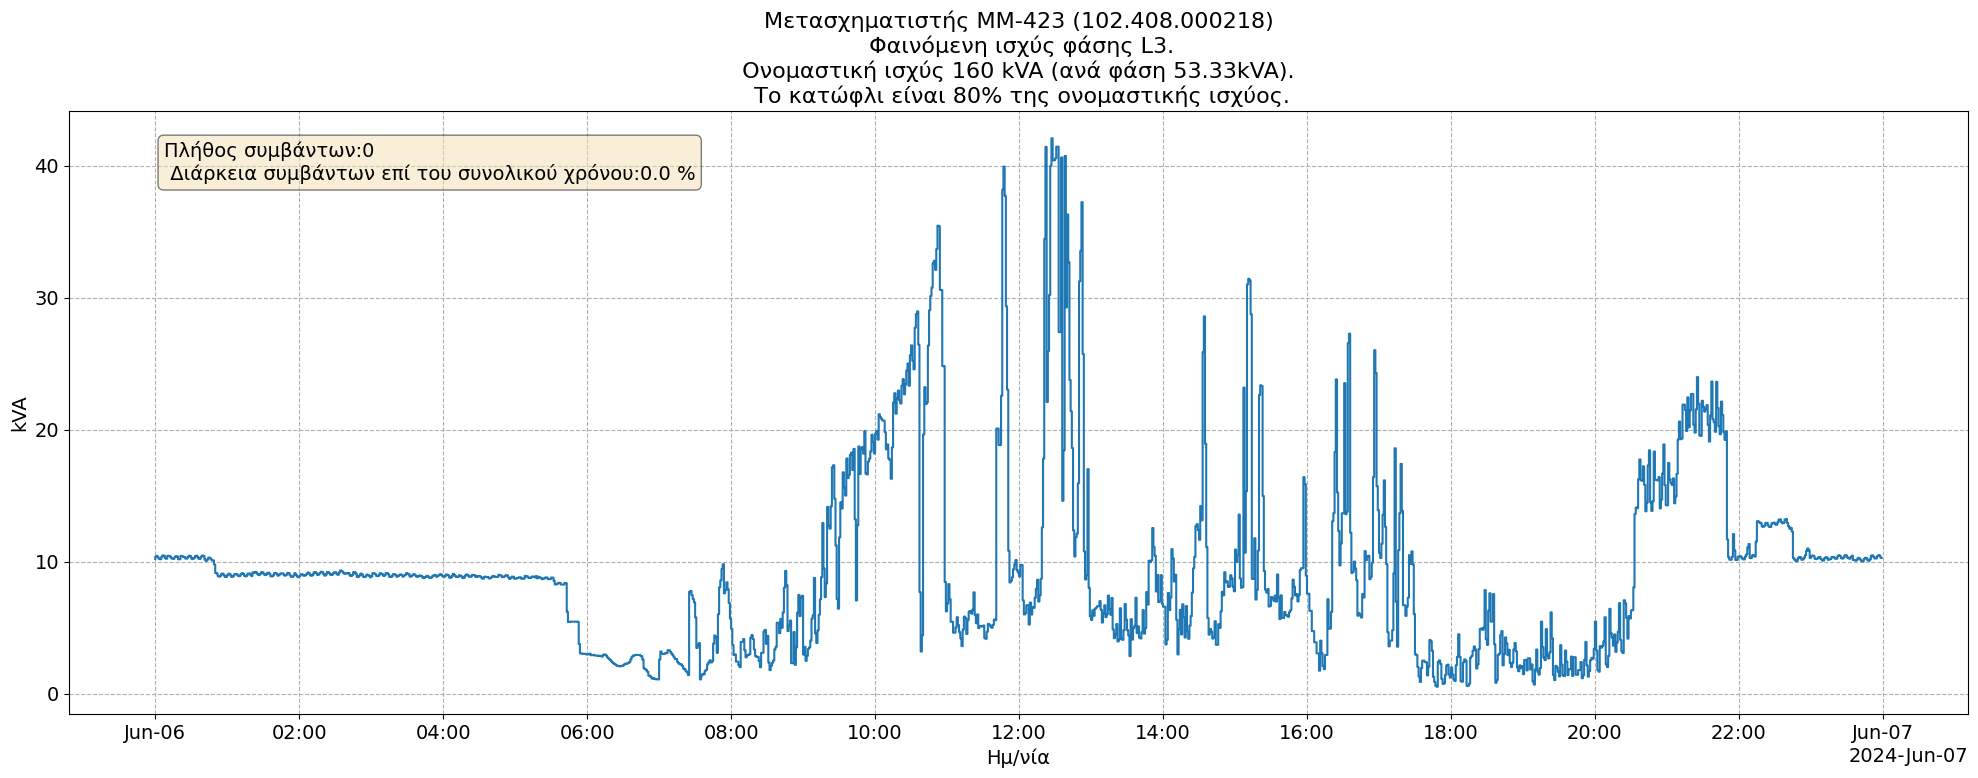

In [16]:
phasedict = {'A':'L1','B':'L2','C':'L3'}

address = 'https://mi6.meazon.com'

r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
acc_token = 'Bearer' + ' ' + r['token']
start_time = '1717621200000'
end_time = '1717707600000'


device = '102.408.000218'

# Define variables
# device = '102.408.000008'
local_tz = pytz.timezone('Europe/Athens')
interval = 1
descriptors = 'curA,curB,curC,vltA,vltB,vltC'


# extract info
[devid, _, acc_token,label] = get_dev_info(device, address)

nominal = get_attr(acc_token,devid,address)


# read data
timethres = 12*3600000
svec = np.arange(int(start_time),int(end_time),timethres)

df = pd.DataFrame([])

for st in svec:
    en = st+timethres-1
    
    if int(end_time)-en<=0: en = int(end_time)
    tmp = read_data(acc_token, devid, address,  str(st), str(en), descriptors)
    if not tmp.empty:
        tmp = tmp.resample(str(interval)+'T').mean()
        # tmp = tmp.dropna()
        df = pd.concat([df,tmp])

del tmp
df.sort_index(inplace=True)

# calculate new variables
for ph in ['A','B','C']:
    df['apwr'+ph] = df['vlt'+ph]*df['cur'+ph]

df['totalcur'] = df['curA']+df['curB']+df['curC']
nomphase = 1000*np.round(nominal/3,2)

# Find power alarms
for ph in ['A','B','C']:
    df['pwrAlarm'+ph] = np.nan
    df.loc[df['apwr'+ph]>0.8*nomphase, 'pwrAlarm'+ph] = 1

# create groups
for ph in ['A','B','C']:
    ind=0
    df['alarm'+ph] = np.nan
    for i in range(1,df.shape[0]):
        if ((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]!=1)):
            ind+=1
            df['alarm'+ph].iloc[i]=ind
        elif((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]==1)):
            df['alarm'+ph].iloc[i]=ind

df = df.dropna(subset=['apwrA','apwrB','apwrC'])
# Plot power alarms
for ph in ['A','B','C']:
    #overall duration within time range
    dtPerc = 100*np.round(df.describe()['alarm'+ph]['count']/df.describe()['cur'+ph]['count'],2)
    # number of distinct events/alarms
    events = df.groupby('alarm'+ph).ngroups

    local_tz = pytz.timezone('Europe/Athens')
    fig, ax = plt.subplots(figsize=(20, 8.0))
    
    plt.step(df.index,np.where(df['pwrAlarm'+ph]==1,df['apwr'+ph]/1000, None), color="red", label="1")
    plt.step(df.index,np.where(df['pwrAlarm'+ph]!=1,df['apwr'+ph]/1000, None), color="tab:blue", label="1")
    

    # plt.setp(ax.xaxis.get_majorticklabels())
    # plt.step(df.index, df['apwrA'], where='post')

    plt.xlabel('Ημ/νία')
    plt.ylabel('kVA')

    # filtered = df['alarmA']>=1
    # ax.scatter(df.index[filtered], df['apwrA'][filtered], color='red') 

    ax.xaxis.set( 
    major_locator = mdates.AutoDateLocator(minticks = 1, 
                                            maxticks = 5,tz=local_tz), 
    ) 

    locator = mdates.AutoDateLocator(minticks = 5, 
                                    maxticks = 20,tz=local_tz) 
    formatter = mdates.ConciseDateFormatter(locator,tz=local_tz) 

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = 'Πλήθος συμβάντων:'+str(events)+'\n Διάρκεια συμβάντων επί του συνολικού χρόνου:'+str(dtPerc)+' %'
    
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.grid(linestyle = "dashed")
    ax.xaxis.set_major_locator(locator) 
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Φαινόμενη ισχύς φάσης '+phasedict[ph]+'.\n Ονομαστική ισχύς '+str(nominal)+' kVA (ανά φάση '+str(nomphase/1000)+'kVA). \n Το κατώφλι είναι 80% της ονομαστικής ισχύος.')
    ax.title.set_size(16)
    fig.tight_layout()
    plt.savefig('pwrAlarm'+str(ph)+'.png',dpi=150)

